<h1>Feather Tutorial</h1>

In [38]:
# from graphviper.dask.client import local_client
# viper_client = local_client(cores=4, memory_limit="4GB")

import dask
dask.config.set(scheduler="synchronous")
# dask.config.set(scheduler="threads")

Read in input images

In [39]:
from xradio.image import read_image
# single dish image
sd_xds = read_image("sd.zarr")
chans_per_chunk = 2**28/(sd_xds.dims["l"]*sd_xds.dims["m"])
chans_per_chunk = min(sd_xds.dims["frequency"], chans_per_chunk)
chunksize = {
    "frequency": chans_per_chunk, "l": sd_xds.dims["l"],
    "m": sd_xds.dims["m"]
}
sd_xds["sky"].chunk(chunksize)
sd_xds

<xarray.Dataset>
Dimensions:          (l: 1024, m: 1024, polarization: 1, time: 1, frequency: 16)
Coordinates:
    declination      (l, m) float64 -0.2371 -0.237 -0.237 ... -0.1628 -0.1627
  * l                (l) float64 0.03723 0.03716 0.03709 ... -0.03709 -0.03716
  * m                (m) float64 -0.03723 -0.03716 -0.03709 ... 0.03709 0.03716
  * polarization     (polarization) <U1 'I'
    right_ascension  (l, m) float64 0.6383 0.6383 0.6383 ... 0.5623 0.5623
  * time             (time) float64 0.0
    velocity         (frequency) float64 1.1e+07 9.626e+06 ... -9.626e+06
  * frequency        (frequency) float64 1.4e+09 1.407e+09 ... 1.493e+09 1.5e+09
Data variables:
    sky              (time, polarization, frequency, l, m) float32 dask.array<chunksize=(1, 1, 16, 1024, 1024), meta=np.ndarray>
Attributes:
    active_mask:      
    beam:             {'major': {'type': 'quantity', 'units': 'rad', 'value':...
    description:      
    direction:        {'lat_pole': 0.0, 'long_pole': 0.0, 'pc': [[1.0, 0.0], ...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

In [40]:
# interferometer image
int_xds = read_image("int.zarr")
chunksize = {
    "frequency": chans_per_chunk, "l": sd_xds.dims["l"],
    "m": sd_xds.dims["m"]
}
int_xds["sky"].chunk(chunksize)
int_xds

<xarray.Dataset>
Dimensions:          (l: 1024, m: 1024, polarization: 1, time: 1, frequency: 16)
Coordinates:
    declination      (l, m) float64 -0.2371 -0.237 -0.237 ... -0.1628 -0.1627
  * l                (l) float64 0.03723 0.03716 0.03709 ... -0.03709 -0.03716
  * m                (m) float64 -0.03723 -0.03716 -0.03709 ... 0.03709 0.03716
  * polarization     (polarization) <U1 'I'
    right_ascension  (l, m) float64 0.6383 0.6383 0.6383 ... 0.5623 0.5623
  * time             (time) float64 0.0
    velocity         (frequency) float64 1.1e+07 9.626e+06 ... -9.626e+06
  * frequency        (frequency) float64 1.4e+09 1.407e+09 ... 1.493e+09 1.5e+09
Data variables:
    sky              (time, polarization, frequency, l, m) float32 dask.array<chunksize=(1, 1, 16, 1024, 1024), meta=np.ndarray>
Attributes:
    active_mask:      
    beam:             {'major': {'type': 'quantity', 'units': 'rad', 'value':...
    description:      
    direction:        {'lat_pole': 0.0, 'long_pole': 0.0, 'pc': [[1.0, 0.0], ...
    history:          None
    object_name:      
    obsdate:          {'format': 'MJD', 'scale': 'UTC', 'type': 'time', 'unit...
    observer:         Karl Jansky
    pointing_center:  {'initial': True, 'value': [0.6, -0.2]}
    telescope:        {'name': 'ALMA', 'position': {'ellipsoid': 'GRS80', 'ty...

In [41]:
if sd_xds["sky"].shape != int_xds["sky"].shape:
    raise RuntimeError("Image shapes differ")

In [50]:
from astropy import units as u

def _beam_area(xds):
    
    if xds.attrs["beam"]:
        beam = xds.attrs["beam"]
        major = u.Quantity(
            f"{beam['major']['value']}{beam['major']['units']}"
        )
        minor = u.Quantity(
            f"{beam['minor']['value']}{beam['minor']['units']}"
        )
        area = major * minor
        return area.to(u.rad*u.rad)
     
    elif "beams" in xds.data_vars:
        # TODO deal when there are multiple beams
        area = xr.DataArray(
            (
                xds.beam.sel(beam_param=["major"]).values
                * xds.beam.sel(beam_param=["minor"]).values
            ).squeeze(3),
            dims=["time", "polarization", "frequency"],
            coords=dict(
                time=xds.time,
                polarization=xds.polarization, 
                frequency=xds.frequency
            )
        )
        bu = u.Unit(xds["beam"].attrs["units"])
        units = bu * bu
        f = units.to(u.rad * u.rad)
        area *= f
        area.attrs["units"] = u.rad * u.rad
        return area
    else:
        raise RuntimeError("xds has no beam (single or multiple")
    
        
# beam_ratio will be a scalar if both images have a single
# beam, or an DataArray if at least one of them has
# multiple beams
beam_ratio = _beam_area(int_xds)/_beam_area(sd_xds)
beam_ratio

<Quantity 0.00598186>

In [48]:
from graphviper.graph_tools.coordinate_utils import make_parallel_coord
from graphviper.utils.display import dict_to_html
from IPython.display import HTML, display

parallel_coords = {}
n_chunks = min(16, sd_xds.dims["frequency"])
parallel_coords["frequency"] = make_parallel_coord(
    coord=sd_xds.frequency, n_chunks=n_chunks
)
display(HTML(dict_to_html(parallel_coords["frequency"])))

In [44]:
from graphviper.graph_tools.coordinate_utils import interpolate_data_coords_onto_parallel_coords

input_data = {"img": sd_xds}
node_task_data_mapping = interpolate_data_coords_onto_parallel_coords(parallel_coords, input_data)
display(HTML(dict_to_html(node_task_data_mapping)))

In [ ]:

from xradio.image import make_empty_apeture_image

def compute_w_single_beam(xds):
    """xds is the single dish (low res)
    xds"""
    pi2 = np.pi * np.pi
    shape = [xds.dims.l, xds.dims.m]
    sics = np.abs(
        xds.attrs["direction"]["reference"]["cdelt"]
    )
    w_xds = make_empty_apeture_image(
        phase_center=[0, 0],
        image_size=[xds.dims.l, xds.dims.m],
        sky_image_cell_size=sics,
        chan_coords=[1],
        pol_coords="I",
        time_coords=[0],
    )
    w = np.zeros(shape)
    maj = xds.attrs["beam"]["major"]
    alpha = u.Quantity(
        f"{maj['value']){maj['units']}"
    )
    alpha = alpha.to(u.rad)
    bmin = xds.attrs["beam"]["minor"]
    beta = u.Quantity(
        f"{bmin['value']){bmin['units']}"
    )
    beta = beta.to(u.rad)
    bpa = xds.attrs["beam"]["pa"]
    phi = u.Quantity(
        f"{bpa['value']){bpa['units']}"
    )
    phi = phi.to(u.rad)
    u = np.zeros(shape)
    v = np.zeros(shape)
    for i, uu in enumerate(w_xds.coords["u"]):
        u[i,:] = uu
    for i, vv in enumerate(w_xds.coords["v"]):
        v[:, i] = vv
    alpha2 = alpha*alpha
    beta2 = beta*beta
    aterm2 = (u*np.sin(phi) - v*np.cos(phi))**2
    bterm2 = (u*np.cos(phi) + v*np.sin(phi))**2
    w = np.exp(
        -pi2/4.0/np.log(2)
        * (
            alpha2*(aterm2 + bterm2)
        )
    )
    # w is an np.array
    return w

    """
    this goes in the node task to compute on a per node basis
    elif "beams" in xds.data_vars:
        # multiple beams
        # a np.array may be too large to hold in memory,
        # so we'll need to go with a dask array for storage
        beams = xds["beams"]
        w = xr.DataArray(
            da.zeros(xds["sky"].shape),
            coords=w_xds.coords,
            dims=w_xds.dims
        )
        bunit = beams.attrs["units"]
        bmaj = beams.sel(beam_param="major").squeeze(5)
        alpha = u.Quantity(
            f"{bmaj.values){bunit})"
        )
        alpha = alpha.to(u.rad)
        bmin = beams.sel(beam_param="minor").squeeze(5)
        beta = u.Quantity(
            f"{bmin.values}{bunit}"
        )
        beta = beta.to(u.rad)
        bpa = beams.sel(beam_param="pa").squeeze(5)
        phi = u.Quantity(
            f"{bpa.values}{bunit}"
        phi = phi.to(u.rad)
        shape = xds["sky"].shape
        u = np.zeros(shape)
        v = np.zeros(shape)
        for i, uu in enumerate(w_xds.coords["u"]):
            u[:, :, :, i,:] = uu
        for i, vv in enumerate(w_xds.coords["v"]):
            v[:, :, :, :, i] = vv
        alpha2 = alpha*alpha
        beta2 = beta*beta
        aterm2 = (u*np.sin(phi) - v*np.cos(phi))**2
        bterm2 = (u*np.cos(phi) + v*np.sin(phi))**2
        w = np.exp(
            -pi2/4.0/np.log(2)
            * (
                alpha2*(aterm2 + bterm2)
            )
        )
        # w is an xr.DataArray which wraps a dask array
        return w
    """

w = None
if "beam" in sd_xds.attrs and sd_xds.attrs["beam"]:
    # w is a [1, 1, 1, l, m] np.array. If not computed
    # here, it will be computed on a per chunk basis 
    # inside the node task
    w = compute_w_single_beam(sd_xds)
    

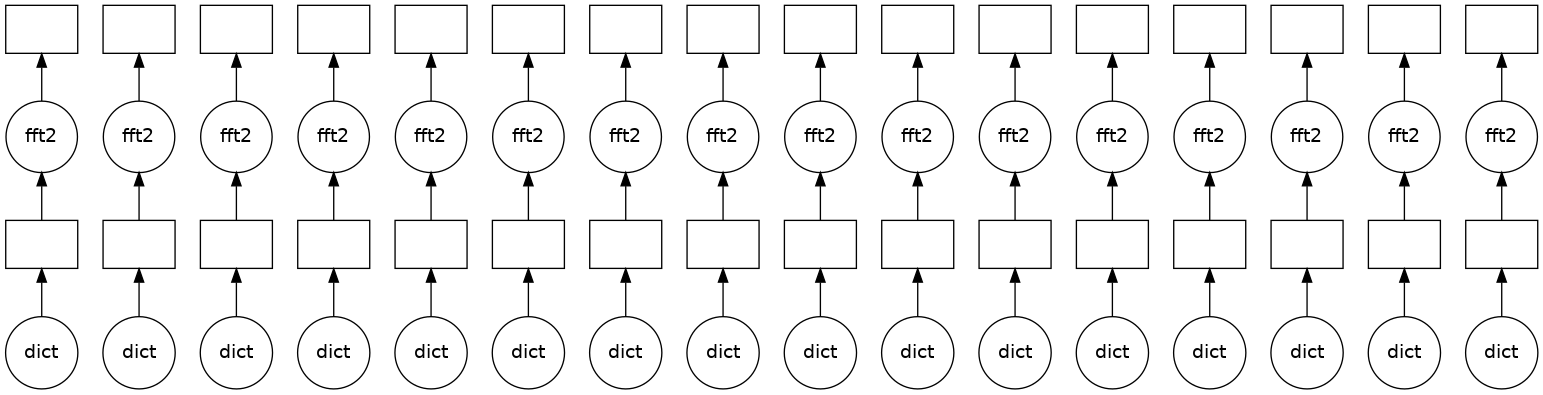

In [45]:
from graphviper.graph_tools.map import map
import dask
import numpy as np
import xarray as xr


def _feather(input_parms):
    display(HTML(dict_to_html(input_parms)))

    
    def _fft(xds):
        display(xds)

        fft_plane = (
            xds['sky'].dims.index(input_parms["axes"][0]),
            xds['sky'].dims.index(input_parms["axes"][1])
        )
        print('fft_plane',fft_plane)
        aperture = np.fft.fftshift(
            np.fft.fft2(
                np.fft.ifftshift(xds.sky, axes=fft_plane),
                axes=fft_plane
            ), axes=fft_plane
         ).real
    
        # img_xds['APERTURE'] = xr.DataArray(aperture, dims=('time','polarization','frequency','u','v'))
        return aperture

    def _compute_w_multiple_beams(xds):
        """xds is the single dish xds"""
        beams = xds["beams"]
        w = np.zeros(xds["sky"].shape)
        bunit = beams.attrs["units"]
        bmaj = beams.sel(beam_param="major").squeeze(5)
        alpha = u.Quantity(
            f"{bmaj.values){bunit})"
        )
        alpha = alpha.to(u.rad)
        bmin = beams.sel(beam_param="minor").squeeze(5)
        beta = u.Quantity(
            f"{bmin.values}{bunit}"
        )
        beta = beta.to(u.rad)
        bpa = beams.sel(beam_param="pa").squeeze(5)
        phi = u.Quantity(
            f"{bpa.values}{bunit}"
        phi = phi.to(u.rad)
        shape = xds["sky"].shape
        u = np.zeros(shape)
        v = np.zeros(shape)
        for i, uu in enumerate(w_xds.coords["u"]):
            u[:, :, :, i, :] = uu
        for i, vv in enumerate(w_xds.coords["v"]):
            v[:, :, :, :, i] = vv
        alpha2 = alpha*alpha
        beta2 = beta*beta
        aterm2 = (u*np.sin(phi) - v*np.cos(phi))**2
        bterm2 = (u*np.cos(phi) + v*np.sin(phi))**2
        w = np.exp(
            -pi2/4.0/np.log(2)
            * (
                alpha2*(aterm2 + bterm2)
            )
        )
        # w is an xr.DataArray which wraps a dask array
        return w

    


    from xradio.image import load_image
    # if input_parms["input_data"] is None: #Load 
    for data_store in input_parms["input_data_store"]:
        xds = load_image(
            data_store, 
            block_des=input_parms["data_selection"]["img"]
        )
        # else:
        #   img_xds = input_parms["input_data"]['img'] #In memory
        aperture = _fft(xds)
        if i == 0:
            int_ap = aperture
        else:
            sd_ap = aperture
            sd_xds = xds
        w = (
            input_parms["w"]
            if "w" in input_parms
            else _compute_w_multiple_beams(sd_xds)
        )
        one_minus_w = 1 - w
        s = input_parms["s"]
        beam_ratio = input_parms["beam_ratio"]
        term = (
            (
                one_minus_w * int_ap["aperture"]
                + s * beam_ratio] * sd_ap["aperture"]
            )
            / (one_minus_w) + s * w
        )
        
            


imgs = [int_xds, sd_xds]
zarr_names = ["int.zarr", "sd.zarr"]

input_parms = {}
input_parms["input_data_store"] = zarr_names
input_parms["axes"] = ('l','m')#(3,4)
input_parms["beam_ratio"] = beam_ratio
input_parms["w"] = w

graph = map(
    input_data=input_data,
    node_task_data_mapping=node_task_data_mapping,
    node_task=_feather,
    input_parms=input_parms,
    in_memory_compute=False
)

dask.visualize(graph, filename="map_graph")
